In [1]:
%pip install -q open_clip_torch

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%env AWS_REQUEST_PAYER=requester
%env AWS_ACCESS_KEY_ID=
%env AWS_SECRET_ACCESS_KEY=
%env AWS_SESSION_TOKEN=

In [10]:
from os.path import join
from glob import glob
import gc

from rastervision.pipeline.file_system.utils import (
    file_exists, file_to_json, json_to_file)
from rastervision.core.box import Box
from rastervision.core.data import (
    RasterioSource, Scene, StatsTransformer)
from rastervision.core.data.raster_source.stac_config import subset_assets
from rastervision.pytorch_learner.dataset import (
    SemanticSegmentationSlidingWindowGeoDataset)

from tqdm.auto import tqdm
import albumentations as A
import numpy as np
import bisect
import torch
from torch.utils.data import ConcatDataset, DataLoader
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.reset_defaults()

import pystac_client
from pystac import ItemCollection
from shapely.geometry import mapping, shape
import geopandas as gpd

In [7]:
bbox = Box(39.96, -75.357, 39.855, -75.13)
catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')
bbox_geometry = mapping(bbox.to_shapely().oriented_envelope)
items = catalog.search(
    intersects=bbox_geometry,
    collections=['naip'],
    datetime='2019-01-01/2019-12-31',
    # query={'eo:cloud_cover': {
    #     'lt': 5
    # }},
).get_all_items()
items

In [57]:
uris = glob('2021_MA/**/*.tif')
len(uris)

742

In [13]:
# uris = uris[:2]

In [58]:
raster_sources = [None] * len(uris)
for i, uri in enumerate(tqdm(uris, desc='Initializing RasterSources')):
    rs = RasterioSource(uri, channel_order=[0, 1, 2], allow_streaming=True)
    raster_sources[i] = rs

Initializing RasterSources: 100%|██████████████████████████████████████████████████████████████████| 742/742 [02:02<00:00,  6.07it/s]


In [118]:
dses = [None] * len(raster_sources)
for i, rs in enumerate(tqdm(raster_sources, desc='Initializing datasets')):
    scene = Scene('', raster_source=rs)
    ds = SemanticSegmentationSlidingWindowGeoDataset(
        scene,
        size=1600,
        stride=1600,
        padding=0,
        transform=A.Resize(224, 224),
    )
    dses[i] = ds

Initializing datasets: 100%|████████████████████████████████████████████████████████████████████| 742/742 [00:00<00:00, 26279.26it/s]


In [119]:
ds = ConcatDataset(dses)
dl = DataLoader(ds, batch_size=16, num_workers=4)
len(ds), len(dl)

(33192, 2075)

---

In [12]:
!curl -O https://opendatasharing.s3.us-west-2.amazonaws.com/SkyScript/ckpt/SkyCLIP_ViT_L14_top50pct.zip
!unzip SkyCLIP_ViT_L14_top50pct.zip

curl: /home/ubuntu/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4281M  100 4281M    0     0  27.0M      0  0:02:38  0:02:38 --:--:-- 25.8M.8M      0  0:02:39  0:01:32  0:01:07 29.8M26.9M      0  0:02:38  0:02:20  0:00:18 25.2M
Archive:  SkyCLIP_ViT_L14_top50pct.zip
   creating: SkyCLIP_ViT_L14_top50pct/
  inflating: SkyCLIP_ViT_L14_top50pct/epoch_20.pt  


In [17]:
from huggingface_hub import hf_hub_download
import torch, open_clip

model_name = 'ViT-L-14'
model, _, preprocess = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

#params:  427,616,513


In [19]:
ckpt_path = 'SkyCLIP_ViT_L14_top50pct/epoch_20.pt'
ckpt = torch.load(ckpt_path)['state_dict']
ckpt = {k[len('module.'):]:v for k, v in ckpt.items()}
message = model.load_state_dict(ckpt)
model = model.cuda().eval()

---

In [120]:
windows = [[_ds.scene.raster_source.crs_transformer.pixel_to_map(w) for w in _ds.windows] for _ds in tqdm(ds.datasets)]
windows = sum(windows, [])
window_geoms = [w.to_shapely() for w in tqdm(windows)]
geojson = geoms_to_geojson(window_geoms)
len(windows)

100%|███████████████████████████████████████████████████████████████████████████████████████| 33192/33192 [00:01<00:00, 28591.52it/s]


33192

In [ ]:
# json_to_file(geojson, 'naip_MA_400_400.json')
# !aws s3 cp naip_MA_400_400.json s3://raster-vision-ahassan/naip/naip_MA_400_400.json

In [106]:
# json_to_file(geojson, 'naip_MA_800_800.json')
# !aws s3 cp naip_MA_800_800.json s3://raster-vision-ahassan/naip/naip_MA_800_800.json

In [121]:
json_to_file(geojson, 'naip_MA_1600_1600.json')
!aws s3 cp naip_MA_1600_1600.json s3://raster-vision-ahassan/naip/naip_MA_1600_1600.json

upload: ./naip_MA_1600_1600.json to s3://raster-vision-ahassan/naip/naip_MA_1600_1600.json


In [32]:
df = gpd.read_file('us-states.json')
df = df[df.name == 'Massachusetts']

In [123]:
embs = torch.zeros(len(ds), 768)
with torch.inference_mode(), tqdm(dl, desc='Creating chip embeddings') as bar:
    i = 0
    for x, _ in bar:
        x = x.cuda()
        emb = model.encode_image(x)
        embs[i:i + len(x)] = emb.cpu()
        i += len(x)
        if i % 50_000 == 0:
            plt.close('all')
            fig, ax = plt.subplots(1, 1)
            df.plot(ax=ax, ec='k', fc='none')
            gpd.GeoDataFrame(geometry=window_geoms[:i]).centroid.plot(ax=ax, c='r', markersize=1)
            plt.show()
embs /= embs.norm(dim=-1, keepdim=True)
embs.shape

Creating chip embeddings: 100%|██████████████████████████████████████████████████████████████████| 2075/2075 [46:34<00:00,  1.35s/it]


torch.Size([33192, 768])

In [72]:
# torch.save(embs, 'skyscript_naip_MA_400_400.pt')

In [73]:
# !aws s3 cp skyscript_naip_MA_400_400.pt s3://raster-vision-ahassan/naip/skyscript_naip_MA_400_400.pt

upload: ./skyscript_naip_MA_400_400.pt to s3://raster-vision-ahassan/naip/skyscript_naip_MA_400_400.pt


In [110]:
# torch.save(embs, 'skyscript_naip_MA_800_800.pt')
# !aws s3 cp skyscript_naip_MA_800_800.pt s3://raster-vision-ahassan/naip/skyscript_naip_MA_800_800.pt

In [124]:
torch.save(embs, 'skyscript_naip_MA_1600_1600.pt')
!aws s3 cp skyscript_naip_MA_1600_1600.pt s3://raster-vision-ahassan/naip/skyscript_naip_MA_1600_1600.pt

upload: ./skyscript_naip_MA_1600_1600.pt to s3://raster-vision-ahassan/naip/skyscript_naip_MA_1600_1600.pt


---

In [74]:
def show_top_chips(chip_scores, ds, top_inds=None, nrows=5, ncols=5, figsize=(12, 12), w_pad=-2.5, h_pad=-2.5):
    plt.close('all')
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.tight_layout(w_pad=w_pad, h_pad=h_pad)
    if top_inds is None:
        top_inds = torch.topk(chip_scores, axs.size).indices
    for ax, i in zip(axs.flat, top_inds):
        ds_idx = bisect.bisect_right(ds.cumulative_sizes, i)
        if ds_idx == 0:
            sample_idx = i
        else:
            sample_idx = i - ds.cumulative_sizes[ds_idx - 1]
        chip_ds = ds.datasets[ds_idx]
        window = chip_ds.windows[sample_idx]
        rs = chip_ds.scene.raster_source
        chip = rs.get_chip(window)
        ax.imshow(chip)
    for ax in axs.flat:
        ax.axis('off')
    plt.show()

In [127]:
T = 0.01
text_queries = [
    # 'buildings',
    # 'trees',
    # 'crop fields',
    # 'river',
    # 'barren land',
    # 'a bridge over a river',
    'airport',
    # 'stadium',
    # 'warehouses',
    # 'storage tanks',
    # 'power plant',
]
assert len(text_queries) == 1
text = tokenizer(text_queries)
with torch.inference_mode():
    text_features = model.encode_text(text.cuda())
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu()
    chip_scores = torch.cosine_similarity(text_features, embs)
    # chip_scores = (chip_scores / T).softmax(dim=0)
    # chip_scores = chip_scores / chip_scores.max()


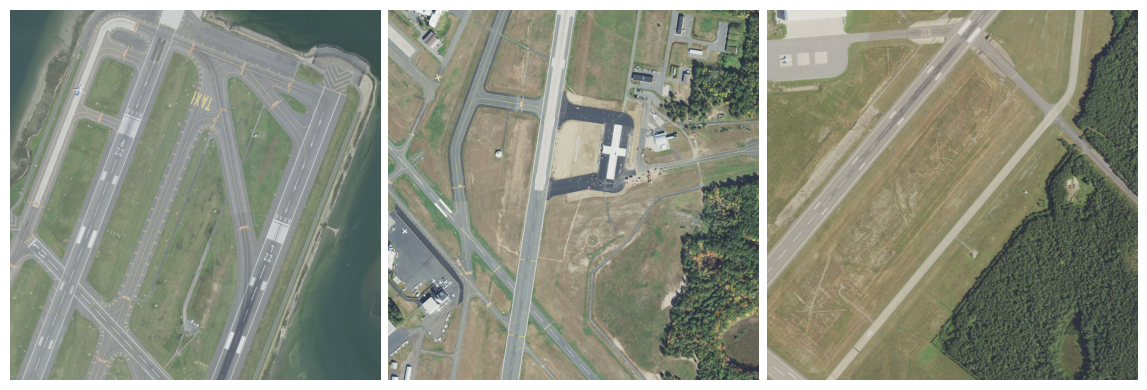

In [128]:
show_top_chips(chip_scores, ds, top_inds=None, nrows=1, ncols=3, figsize=(12, 12))
# show_top_chips(torch.rand(len(ds)), ds, top_inds=None, nrows=1, ncols=3, figsize=(12, 12))

---